## Team members


*   Anghelo Daniel Pérez Martínez (A01795323)
*   Luis Daniel Ortega Muñoz (A01795197)
*   Emil Khaleb Palomino Bruzzón (A00826811)
*   José de Jesús Peña Rodríguez (A01794940)
*   Gerardo Miguel Pérez Solis (A01795599)



# TC 5033
## Deep Learning
## Fully Connected Deep Neural Networks

#### Activity 1b: Implementing a Fully Connected Network for Kaggle ASL Dataset

- Objective

The aim of this part of the activity is to apply your understanding of Fully Connected Networks by implementing a multilayer network for the [Kaggle ASL (American Sign Language) dataset](https://www.kaggle.com/datasets/grassknoted/asl-alphabet). While you have been provided with a complete solution for a Fully Connected Network using Numpy for the MNIST dataset, you are encouraged to try to come up with the solution.

- Instructions

    This activity requires submission in teams of 3 or 4 members. Submissions from smaller or larger teams will not be accepted unless prior approval has been granted (only due to exceptional circumstances). While teamwork is encouraged, each member is expected to contribute individually to the assignment. The final submission should feature the best arguments and solutions from each team member. Only one person per team needs to submit the completed work, but it is imperative that the names of all team members are listed in a Markdown cell at the very beginning of the notebook (either the first or second cell). Failure to include all team member names will result in the grade being awarded solely to the individual who submitted the assignment, with zero points given to other team members (no exceptions will be made to this rule).

    Load and Preprocess Data: You are provided a starter code to load the data. Be sure to understand the code.

    Review MNIST Notebook (Optional): Before diving into this activity, you have the option to revisit the MNIST example to refresh your understanding of how to build a Fully Connected Network using Numpy.

    Start Fresh: Although you can refer to the MNIST solution at any point, try to implement the network for the ASL dataset on your own. This will reinforce your learning and understanding of the architecture and mathematics involved.

    Implement Forward and Backward Pass: Write the code to perform the forward and backward passes, keeping in mind the specific challenges and characteristics of the ASL dataset.
    
     Design the Network: Create the architecture of the Fully Connected Network tailored for the ASL dataset. Choose the number of hidden layers, neurons, and hyperparameters judiciously.

    Train the Model: Execute the training loop, ensuring to track performance metrics such as loss and accuracy.

    Analyze and Document: Use Markdown cells to document in detail the choices you made in terms of architecture and hyperparameters, you may use figures, equations, etc to aid in your explanations. Include any metrics that help justify these choices and discuss the model's performance.  

- Evaluation Criteria

    - Code Readability and Comments
    - Appropriateness of chosen architecture and hyperparameters for the ASL dataset
    - Performance of the model on the ASL dataset (at least 70% acc)
    - Quality of Markdown documentation

- Submission

Submit this Jupyter Notebook in canvas with your complete solution, ensuring your code is well-commented and includes Markdown cells that explain your design choices, results, and any challenges you encountered.


## Required imports

In [ ]:
import numpy as np
import string
import pandas as pd
import matplotlib.pyplot as plt
import cv2 as cv
import os

%load_ext autoreload
%autoreload 2
#################################
%matplotlib inline


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Loading the dataset

Run the following cell when running this in Google Colab.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Set the `DATA_PATH` to the path of the base `asl_data` directory. Then, load both the train and validation datasets into a pandas `DataFrame`.

In [ ]:
# Don't forget to update this to reflect your execution environment!
DATA_PATH = '/content/drive/MyDrive/Team_52/Activity_1b/asl_data'

train_df = pd.read_csv(os.path.join(DATA_PATH, 'sign_mnist_train.csv'))
valid_df = pd.read_csv(os.path.join(DATA_PATH, 'sign_mnist_valid.csv'))

In [ ]:
# Run this to get a preview of the first 5 elements of the train dataset.
train_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,12,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


## Preparing the data

Separate the input features from the target label. This is done in the following steps for both the train and validation sets:
1. Create a numpy array from the `label` column in the original sets and assign it to a variable (either `y_train` or `y_val`)
2. Delete the `label` column from both data frames
3. Convert each data frame into a numpy array and assign them to a variable (`x_train` and `x_val`)

In [ ]:
y_train = np.array(train_df['label'])
y_val = np.array(valid_df['label'])
del train_df['label']
del valid_df['label']
x_train = train_df.values.astype(np.float32)
x_val = valid_df.values.astype(np.float32)

#### Splitting the validation and test datasets

Let's start by defining the `shuffle_dataset` utility function, which can be reused anytime `x` and `y` need to be shuffled.

In [ ]:
def shuffle_dataset(x, y):
    """Shuffles the dataset. The size of the input arrays must match, otherwise an error is thrown.

    Args:
        x: Input features.
        y: Labels.

    Returns:
        Shuffled x and y.
    """
    assert x.shape[0] == y.shape[0], 'The lenghts of x and y are not of the same.'

    indexes = np.arange(x.shape[0])
    np.random.shuffle(indexes)
    shuffled_x = x[indexes]
    shuffled_y = y[indexes]

    return shuffled_x, shuffled_y

Now, let's define the `split_val_test` function. It will receive the input features array `x`, and the labels array `y`.

By default, it will split them such that half of the elements are used for validation and the other half comprises the test dataset, but this can be overriden by the `pct` variable, which takes a number between 0 and 1 representing the percentage of data that will be used for the test set, with the remainder being allocated as part of the validation set.

This will additionally shuffle the input arrays before performing the split, unless the optional parameter `shuffle` is set to `False`.

In [ ]:
def split_val_test(x, y, pct=0.5, shuffle=True):
    """Splits a dataset into validation and test sets. The size of the input arrays must match, otherwise an error is thrown.

    Args:
        x: Input features.
        y: Labels.
        pct: Percentage of data to use for the test set. Default is 0.5.
        shuffle: Whether to shuffle the data before splitting. Default is True.

    Returns:
        A tuple containing the test set features, test set labels, validation set
        features, and validation set labels.
    """

    # Ensure that the lenght of x and y are the same before proceeding
    assert x.shape[0] == y.shape[0], 'The lenghts of x and y are not of the same.'

    if shuffle:
        x, y = shuffle_dataset(x, y)

    # obtener la cantidad de datos que se asignarán para el conjunto prueba
    cantidad_prueba = int(x.shape[0] * pct)

    # dividir el conjunto original, primero asignar el conjunto prueba
    x_test = x[:cantidad_prueba]
    y_test = y[:cantidad_prueba]

    # y después el conjunto de validación
    x_val = x[cantidad_prueba:]
    y_val = y[cantidad_prueba:]

    return x_test, y_test, x_val, y_val

In [ ]:
x_val, y_val, x_test, y_test = split_val_test(x_val, y_val)

We now need to create a way to convert from the original labels to the actual letters of the alphabet they represent. We can achieve this by creating a list in which the index of each letter corresponds to the label assigned to it in the dataset.

Note: the original data set does not contain samples for the letters `j` and `z`, so we need to remove them from our alphabet.

In [ ]:
alphabet = list(string.ascii_lowercase)
alphabet.remove('j')
alphabet.remove('z')
print(len(alphabet))

24


### **Normalise**

Start by defining the normalization function.

In [ ]:
def normalise(x_mean, x_std, x):
    """Normalizes data using the mean and standard deviation.

    Args:
    x_mean: Mean of the data.
    x_std: Standard deviation of the data.
    x: Data to be normalized.

    Returns:
    Normalized data.
    """
    return (x - x_mean) / x_std

Compute the mean and standard deviation for the train dataset.

In [ ]:
x_mean = x_train.mean()
x_std = x_train.std()

Use the computed values for the mean and standard deviation to normalise all of the `x` datasets.

Be sure to use the mean and std. deviation values from the train dataset only; this will prevent data leakage.

In [ ]:
x_train = normalise(x_mean, x_std, x_train)
x_val = normalise(x_mean, x_std, x_val)
x_test = normalise(x_mean, x_std, x_test)

## Plotting samples

Each of the samples is comprised of 784 columns, with each of them representing the value of a given pixel on a 28x28 representation of a letter in ASL. Using `matplotlib`, we can create a function that takes any sample from the dataset and plots its image representation.

The following is the implementation for `plot_image`:

In [ ]:
def plot_image(data, image_label):
    """
    Plots the given data as an image.

    Args:
    x: The data to be rendered.
    image_label: The corresponding label for the image.

    Returns:
    None

    """

    # Convert the linear 1D array to a 2D array with each of the pixel values.
    # For this specific problem, we know before-hand that the image should be of size 28x28.
    img_array = data.reshape((28, 28))

    # Then use matlplotlib to plot the given values in grayscale, alongside the title of the letter it represents.
    plt.figure(figsize=(5,5))
    plt.imshow(img_array, cmap='gray')
    plt.title(f'Letter: {alphabet[image_label]}')
    plt.show()

Now, let's take a random sample from the training set to verify that our `plot_image` function works as expected.

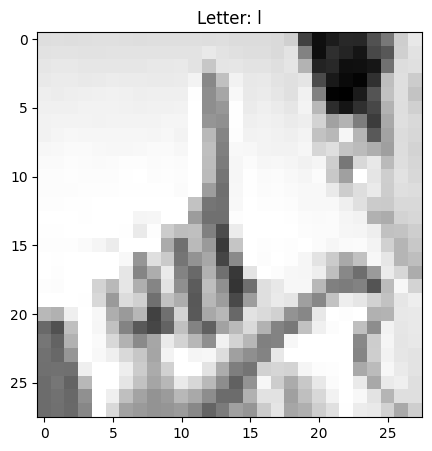

In [ ]:
random_id = np.random.randint(len(x_train))
plot_image(x_train[random_id], y_train[random_id],)

## Model equations

The following are the mathematical equations representing the model we will be training during this excercise:

1$$z^1 = W^1 X + b^1$$

$$a^1 = ReLU(z^1) $$

$$z^2 = W^2 a^1 + b^2$$

$$\hat{y} = \frac{e^{z^{2_k}}}{\sum_j{e^{z_j}}}$$


$$ \mathcal{L}(\hat{y}^{i}, y^{i}) =  - y^{i}  \ln(\hat{y}^{i}) = -\ln(\hat{y}^i)$$


$$ \mathcal{J}(w, b) =  \frac{1}{num\_samples} \sum_{i=1}^{num\_samples}-\ln(\hat{y}^{i})$$

## Additional functions

### Mini batches

The `create_minibatches` function is used during training to improve performance by randomly splitting the data into smaller groups (i.e., batches).

This function will return smaller batches of `x` and `y` with each containing at most `mb_size` items. Note that the returning value is a generator, which means that the batches won't be allocated until the results are iterated.

In [ ]:
def create_minibatches(mb_size, x, y, shuffle = True):
    """
    Divides the data into smaller groups (mini-batches) for training.

    Args:
      mb_size: Mini-batch size.
      x: Input data.
      y: Labels.
      shuffle: Whether to shuffle the data before creating mini-batches.
               Defaults to True.

    Returns:
      A generator that yields mini-batches of data.
    """

    # Throw an error if the sizes of x and y don't match
    assert x.shape[0] == y.shape[0], 'The lenghts of x and y are not of the same.'

    if shuffle:
        x, y = shuffle_dataset(x, y)

    total_data = x.shape[0]
    return ((x[i:i+mb_size], y[i:i+mb_size]) for i in range(0, total_data, mb_size))

## Defining the Linear, ReLU, and Sequential classes

Before creating and training our model, we first need to implement the python classes that will represent the different entities within our model. Because we are working with a multilayer fully connected neural network, we need to define the objects representing the neural network and each layer whithin it; as well as the ReLU implementation. All of them will implement the forward and backward passes.

The `np_tensor` class is defined in order to be able to add attributes at runtime without changing the underlying tensor; in this case weight and bias attributes.

In [ ]:
class np_tensor(np.ndarray): pass

###  **Linear class**

The `Linear` class will represent a layer in our neural network. It is initialized with the input and output sizes. The initial weights are randomized using Kaiming He initialization, while biases are initially zero.

The forward pass can be invoked by calling the object as a function (which in turn calls the `__call__` method), while the backward pass can be invoked with the `backward` function.

Esta clase representará una capa lineal en una red neuronal, es decir, que está complementamente conectada. El método forward propagará hacia adelante el producto punto de W x + b. Mientras que el método backward ajustará los parámetros para disminuir el costo.

In [ ]:
"""
The Linear class represents a single layer in a neural network. Each layer will be comprised of the weights and biases.
"""
class Linear():

    def __init__(self, input_size, output_size):
        """
        Initializes a new instance of the neural network layer with the provided input and output sizes.
        """
        self.W = (np.random.randn(output_size, input_size) / np.sqrt(input_size/2)).view(np_tensor)
        self.b = (np.zeros((output_size, 1))).view(np_tensor)


    def __call__(self, X):
        """
        Applies the forward pass of the neural network layer.
        This consists of the cross product of the weights and the input, and adding the bias.
        """
        Z = self.W @ X + self.b
        return Z


    def backward(self, X, Z):
        """
        Applies the backward pass of the neural network layer to adjust the weights and biases.
        """
        X.grad = self.W.T @ Z.grad
        self.W.grad = Z.grad @ X.T
        self.b.grad = np.sum(Z.grad, axis = 1, keepdims=True)

### **ReLU class**

Next is the implementation of the ReLU function, also known as Rectified Linear Unit activation function.

In the forward pass, it will activate only if the given value is greater than zero.

In the backward pass, it will

In [ ]:
'''
Implementation of the Rectified Linear Unit activation function
'''
class ReLU():
    def __call__(self, Z):
        """
        Forward pass, applies the activation function. Will return the input if it is greater than zero; otherwise zero.
        """
        return np.maximum(0, Z)


    def backward(self, Z, A):
        """
        Backward pass, updates the gradients based on the activation function.
        """
        Z.grad = A.grad.copy()
        Z.grad[Z <= 0] = 0

### **SequentialLayers class**

The `SequentialLayers` class will represent the whole neural network, and can be used to interact with it.

For this problem, the layers can be a neuron layer represented by a `Linear` instance, or an activation layer represented by a `ReLU` instance.

In [ ]:
'''
Represents a neural network, comprised of sequential layers.
Also provides methods to update it, predict a label and to perform forward and backward passes.
'''
class SequentialLayers():

    def __init__(self, layers):
        """
        Initializes a new instance of the neural network with the provided layers.
        Layers can be either Linear or ReLU instances.
        """
        self.layers = layers
        self.x = None
        self.outputs = {}

    def __call__(self, X):
        """
        Performs a forward pass with the provided input to the neural network.
        """

        # Initializes the outputs of the input layer to be the provided input
        self.x = X
        self.outputs['l0'] = self.x

        # For each layer, update the current value of x, and also store it in the outputs dictionary for future reference.
        for i, layer in enumerate(self.layers, 1):
            self.x = layer(self.x)
            self.outputs['l'+str(i)] = self.x

        # self.x will be the output for the last layer.
        return self.x


    def backward(self):
        """
        Performs a backward pass to update the weights and biases of the neural network.
        This works by iterating the layers in reverse and calling their backward methods.
        """
        for i in reversed(range(len(self.layers))): #  recorre las capas en orden inverso
            # llama al método backward de la capa que se está trabajando
            self.layers[i].backward(self.outputs['l'+str(i)], self.outputs['l'+str(i+1)])

    def update(self, learning_rate = 1e-3):
        """
        Updates the weights and biases of each layer in the neural network
        based on the gradients and the learning rate.
        """
        for layer in self.layers:
            # Skip ReLU instances
            if isinstance(layer, ReLU): continue

            layer.W = layer.W - learning_rate * layer.W.grad
            layer.b = layer.b - learning_rate * layer.b.grad

    def predict(self, X):
        """
        Performs a forward pass based on the provided input to predict the label.
        """
        return np.argmax(self.__call__(X))

### Cost Function

For the cost function used during training, we will implement a softmax cross entropy function. It will

Se creará la función **softmaxXEntropy** la cual convertirá los valores de salida de la red en la probabilidad de que cada una sea la clase correcta, además, mide la discrepancia entre las predicciones y la clase correcta.

In [ ]:
'''
Softmax cross entropy function to be used as the cost function during training.
Softmax takes the outputs of the network and converts them into probabilities,
while cross entropy measures the difference between the predicted probabilities and the true labels.
'''
def softmaxXEntropy(x, y):
    # Softmax probabilities
    batch_size = x.shape[1]
    exp_scores = np.exp(x)
    probs = exp_scores / exp_scores.sum(axis = 0)
    preds = probs.copy()

    # Cross entropy loss
    y_hat = probs[y.squeeze(), np.arange(batch_size)]
    cost = np.sum(-np.log(y_hat)) / batch_size

    # Update gradients of x
    probs[y.squeeze(), np.arange(batch_size)] -= 1
    x.grad = probs.copy()

    return preds, cost


### Accuracy function

The following is the accuracy function that will be used as our target to optimize against during training. The accuracy is defined as the ratio of correct predictions divided by the total amount of predictions.

In [ ]:
def accuracy(x, y, mb_size):
    correct = 0
    total = 0

    # Create minibatches and
    for i, (x, y) in enumerate(create_minibatches(mb_size, x, y)):
        pred = model(x.T.view(np_tensor))

        # Correct predictions are the ones in which the maximum value in the output layer of the model
        # corresponds to the actual labels
        correct += np.sum(np.argmax(pred, axis=0) == y.squeeze()) # predicciones correctas
        total += pred.shape[1] # numero total de predicciones

    return correct/total

### **Training loop**

Now, let's implement the main training function. During each epoch (the number of which are defined by the user), this will:
- Create the micro-batches from the input data and the given value of `mb_size` (or default to 128)
- Perform a forward pass through the network
- Compute the cost using the `softm

En esta sección, creamos dos funciones, train y accuracy

**train** entrenará al modelo utilizando los datos de entrenamiento durante el número de ciclos o epocas que hayamos definido, además, actualizará los pesos de cada capa despues de procesar cada mini batch

**accuracy** calculará la precisión del modelo comparando las predicciones con las etiquetas reales

In [ ]:
def train(model, epochs, mb_size=128, learning_rate = 1e-3):
    """Trains the neural network model using the training data.

    Args:
      model: The neural network model to train.
      epochs: The number of training epochs.
      mb_size: The mini-batch size. Default is 128.
      learning_rate: The learning rate for updating the model weights.
                      Default is 1e-3.

    Returns:
      None
    """
    for epoch in range(epochs): # un ciclo de la cantidad de epocas definidas por el usuario
        for i, (x, y) in enumerate(create_minibatches(mb_size, x_train, y_train)): # se crean los mini batches y se crea un ciclo de la cantidad creada
            scores = model(x.T.view(np_tensor)) #  # forward pass
            _, cost = softmaxXEntropy(scores, y) # aplicar softmax cross entropy para obtener probabilidades
            model.backward() # se llama el método backward del modelo
            model.update(learning_rate) # se actualizan los parametros

        # At the end of each epoch, print the cost and accuracy for that given iteration.
        print(f'cost: {cost}, accuracy: {accuracy(x_val, y_val, mb_size)}')

## Create your model and train it

### Model description

The ML model that will be used consists of a deep neural network. This model will consist of an input layer of size 784 (one for each feature in the dataset), 4 hidden layers and an output layer of size 24 (one for each of the labels in the dataset).

### **Modelo e hiperparámetros**

# Descripción del modelo

El modelo tiene **4 capas ocultas** y **24 neuronas en la capa de salida**.

### Capas ocultas:
- **Capa 1**: 512 neuronas (784 -> 512)
- **Capa 2**: 256 neuronas (512 -> 256)
- **Capa 3**: 128 neuronas (256 -> 128)
- **Capa 4**: 64 neuronas (128 -> 64)

### Capa de salida:
- La última capa tiene **24 neuronas** (64 -> 24), debido a que estamos reconociendo 24 letras del alfabeto, ya que se eliminaron las letras 'j' y 'z'.

### Parámetros del modelo:
- **Batch size**: 128 (para lograr una mejor generalización y evitar el ruido)
- **Learning rate**: 1e-3
- **Número de epochs**: 20


In [ ]:
model = SequentialLayers([ # Definimos un modelo secuencial multicapa
    Linear(784, 512), ReLU(),
    Linear(512, 256), ReLU(),
    Linear(256, 128), ReLU(),
    Linear(128, 64), ReLU(),
    Linear(64, 24)
])

mb_size = 128
learning_rate = 0.001
epochs = 20
train(model, epochs, mb_size, learning_rate)

costo: 0.015240141635396807, accuracy: 0.7785833798103736
costo: 0.0033027783291856567, accuracy: 0.7769102063580591
costo: 0.002824279000483069, accuracy: 0.7766313441160066
costo: 0.0015859648711529272, accuracy: 0.7805354155047407
costo: 0.0009277558142859593, accuracy: 0.7791411042944786
costo: 0.0006137787028369813, accuracy: 0.7783045175683212
costo: 0.00065674788574971, accuracy: 0.7799776910206359
costo: 0.0006205321965322455, accuracy: 0.7788622420524262
costo: 0.000662970056122667, accuracy: 0.7788622420524262
costo: 0.0003729247235296015, accuracy: 0.7788622420524262
costo: 0.0005385568302487026, accuracy: 0.7796988287785834
costo: 0.00032199065071871684, accuracy: 0.7791411042944786
costo: 0.0002985052971665559, accuracy: 0.7802565532626883
costo: 0.00030876722601601726, accuracy: 0.7802565532626883
costo: 0.00025440752005357145, accuracy: 0.7805354155047407
costo: 0.00034803793623413844, accuracy: 0.7802565532626883
costo: 0.00012301166256457327, accuracy: 0.78081427774679

## Results

- **Accuracy** en los datos de validación: **0.814**
- **Accuracy** en los datos de prueba: **0.81176**
- **Función de costo**: **0.00047**

In [ ]:
print(accuracy(x_test, y_test, mb_size))

0.7911321807027328


### Test your model on Random data from your test set

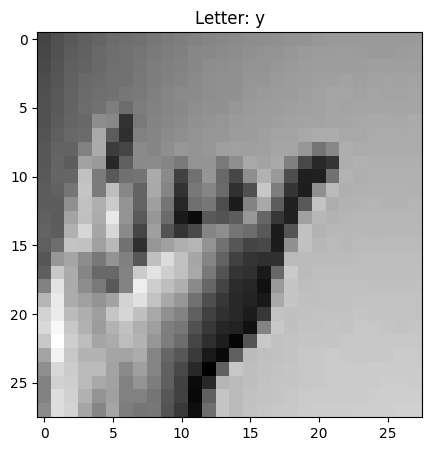

el valor predicho es: y el valor real es: y


In [ ]:
idx = np.random.randint(len(y_test))  # Generamos un índice aleatorio para seleccionar una imagen al azar
plot_image(x_test[idx].reshape(28, 28), y_test[idx])  # Mostramos la imagen
pred = model.predict(x_test[idx].reshape(-1, 1))  # Realizamos una predicción con el modelo sobre la imagen seleccionada

# Imprimimos el valor predicho y el valor real de la etiqueta
print(f'el valor predicho es: {alphabet[pred]} el valor real es: {alphabet[y_test[idx]]}')


# Experimentación usando la funcion de Keras

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

model_2 = Sequential()

# Capa oculta con funcion RELU
model_2.add(Dense(units=512, activation='relu', input_shape=(784,)))  # Capa densa con 512 neuronas

# Agregamos las capas ocultas
model_2.add(Dense(units=256, activation='relu'))  # Capa con 256 neuronas
model_2.add(Dense(units=128, activation='relu'))  # Capa  con 128 neuronas
model_2.add(Dense(units=64, activation='relu'))   # Capa con 64 neuronas

# Capa de salida (para clasificación)
model_2.add(Dense(units=24, activation='softmax'))  # 24 unidades para 24 letras


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### **Loop de entrenamiento**

In [ ]:
model_2.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


history = model_2.fit(x_train, y_train,
                    batch_size=128,
                    epochs=20,
                    validation_data=(x_val, y_val))

Epoch 1/20
215/215 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - accuracy: 0.6463 - loss: 1.2173 - val_accuracy: 0.8020 - val_loss: 0.7811
Epoch 2/20
215/215 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - accuracy: 0.9874 - loss: 0.0522 - val_accuracy: 0.7337 - val_loss: 1.2011
Epoch 3/20
215/215 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.9885 - loss: 0.0382 - val_accuracy: 0.7928 - val_loss: 1.0096
Epoch 4/20
215/215 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.9950 - loss: 0.0188 - val_accuracy: 0.7716 - val_loss: 1.1644
Epoch 5/20
215/215 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.9924 - loss: 0.0268 - val_accuracy: 0.8093 - val_loss: 0.9821
Epoch 6/20
215/215 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 1.0000 - loss: 1.7758e-04 - val_accuracy: 0.8090 - val_loss: 0.9902
Epoch 7/20
215/215 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 1.0000 - loss: 9.1930e-05 - val_accuracy: 0.8107 - val_loss: 1.0049
Epoch 8/20
215/215 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 1.0000 - loss: 6.2620e

# Comentarios

El modelo arroja resultados de **accuracy** similares utilizando la librería Keras en comparación con las funciones creadas en nuestro modelo. Ambas implementaciones lograron un **accuracy** en los datos de validación no mayor a **0.814**.
